In [17]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [18]:
!pip install ucimlrepo


from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
import sys
import os
import pandas as pd



Defaulting to user installation because normal site-packages is not writeable


In [19]:
# Caminho absoluto para a pasta src
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
src_path_2 = os.path.abspath(os.path.join(os.getcwd(), '..', 'src/modelos'))
sys.path.append(src_path)
sys.path.append(src_path_2)

from model_wizard import buscar_melhor_wisard
from model_mlp import busca_melhores_mlp
from tratamento_dados import preprocess_numeric_data_wizard,preprocess_data_standart_scale
from metricas import plot_confusion_matrix, classification_metrics
from smote import SmoteTransformer

## Quinto Dataset

In [20]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
dermatology = fetch_ucirepo(id=33) 
  
# data (as pandas dataframes) 
X = dermatology.data.features 
y = dermatology.data.targets 
  
# metadata 
print(dermatology.metadata) 
  
# variable information 
print(dermatology.variables) 


{'uci_id': 33, 'name': 'Dermatology', 'repository_url': 'https://archive.ics.uci.edu/dataset/33/dermatology', 'data_url': 'https://archive.ics.uci.edu/static/public/33/data.csv', 'abstract': 'Aim for this dataset is to determine the type of Eryhemato-Squamous Disease.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 366, 'num_features': 34, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1998, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C5FK5P', 'creators': ['Nilsel Ilter', 'H. Guvenir'], 'intro_paper': {'ID': 387, 'type': 'NATIVE', 'title': 'Learning differential diagnosis of erythemato-squamous diseases using voting feature intervals', 'authors': 'H. Altay Güvenir, G. Demiröz, N. Ilter', 'venue': 'Artif. Intell. Medicine', 'year': 1998, 'journal': No

### Visualização de datasets

In [21]:
import numpy as np
print("Features:")
print(X.head())
print("\nTargets únicos:")
print(np.unique(y))

# Identificar colunas categóricas e numéricas
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

print("\nColunas categóricas:", categorical_cols)
print("Colunas numéricas:", numeric_cols)

Features:
   erythema  scaling  definite-borders  itching  koebner phenomenon  \
0         2        2                 0        3                   0   
1         3        3                 3        2                   1   
2         2        1                 2        3                   1   
3         2        2                 2        0                   0   
4         2        3                 2        2                   2   

   polygonal papules  follicular papules  oral-mucosal involvement  \
0                  0                   0                         0   
1                  0                   0                         0   
2                  3                   0                         3   
3                  0                   0                         0   
4                  2                   0                         2   

   knee elbow involvement  scalp involvement  ...  focal hypergranulosis  \
0                       1                  0  ...                 

### Tratamento de Dados

In [22]:
# Inicializa o SMOTE transformer
smote_transformer = SmoteTransformer(random_state=42)

# Aplica SMOTE
X, y = smote_transformer.fit_transform(X, y)

# Mostra as dimensões após SMOTE
print("\nTamanho do conjunto após SMOTE:", X.shape)
print("Tamanho dos rótulos  após SMOTE:", y.shape)


Tamanho do conjunto após SMOTE: (666, 34)
Tamanho dos rótulos  após SMOTE: (666, 1)


In [23]:
# Processa os dados
X_processed, y_encoded, le = preprocess_numeric_data_wizard(X, y, numeric_cols)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Exibe as dimensões dos conjuntos de treino e teste
print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)
print("Tamanho dos rótulos de treino:", y_train.shape)
print("Tamanho dos rótulos de teste:", y_test.shape)

print("\nExemplo de X_train (primeiras 5 linhas):")
print(X_train[:5])

print("\nExemplo de y_train (primeiros 5 rótulos):")
print(y_train[:5])

print("\nExemplo de X_test (primeiras 5 linhas):")
print(X_test[:5])

print("\nExemplo de y_test (primeiros 5 rótulos):")
print(y_test[:5])


Tamanho do conjunto de treino: (466, 272)
Tamanho do conjunto de teste: (200, 272)
Tamanho dos rótulos de treino: (466,)
Tamanho dos rótulos de teste: (200,)

Exemplo de X_train (primeiras 5 linhas):
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]

Exemplo de y_train (primeiros 5 rótulos):
[3 2 5 0 5]

Exemplo de X_test (primeiras 5 linhas):
[[1 1 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]]

Exemplo de y_test (primeiros 5 rótulos):
[4 0 1 5 4]


#### Métricas

In [24]:

best_model, best_params, best_score, random_search = buscar_melhor_wisard(X_train, y_train)

print("Melhores parâmetros encontrados:", best_params)
print("Melhor acurácia:", best_score)

# Faz predição codificada
y_train_pred_encoded = random_search.predict(X_train)

# Imprime relatório de classificação com rótulos originais
classification_metrics(y_train, y_train_pred_encoded, le)

Melhores parâmetros encontrados: {'wisard__tuple_size': 11, 'wisard__bleaching': True}
Melhor acurácia: 0.9678108629721534
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        78
           2       0.80      1.00      0.89        78
           3       1.00      1.00      1.00        78
           4       1.00      0.74      0.85        77
           5       1.00      1.00      1.00        77
           6       1.00      1.00      1.00        78

    accuracy                           0.96       466
   macro avg       0.97      0.96      0.96       466
weighted avg       0.97      0.96      0.96       466



### Predição

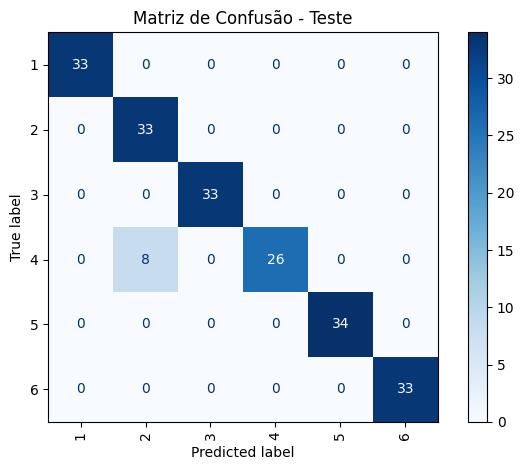

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        33
           2       0.80      1.00      0.89        33
           3       1.00      1.00      1.00        33
           4       1.00      0.76      0.87        34
           5       1.00      1.00      1.00        34
           6       1.00      1.00      1.00        33

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200



In [25]:
# Predição no teste
y_test_pred = random_search.predict(X_test)

plot_confusion_matrix(y_test, y_test_pred, le, maior = False, title="Matriz de Confusão - Teste")
classification_metrics(y_test, y_test_pred, le)

## MLP

### Tratamento de Dados

In [12]:
# Inicializa o SMOTE transformer
smote_transformer = SmoteTransformer(random_state=42)

# Aplica SMOTE
X, y = smote_transformer.fit_transform(X, y)

# Mostra as dimensões após SMOTE
print("\nTamanho do conjunto após SMOTE:", X.shape)
print("Tamanho dos rótulos  após SMOTE:", y.shape)


Tamanho do conjunto após SMOTE: (666, 34)
Tamanho dos rótulos  após SMOTE: (666, 1)


In [13]:
X_processed, y_encoded, le = preprocess_data_standart_scale(X, y, categorical_cols, numeric_cols)
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)
# Exibe as dimensões dos conjuntos de treino e teste
print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)
print("Tamanho dos rótulos de treino:", y_train.shape)
print("Tamanho dos rótulos de teste:", y_test.shape)

print("\nExemplo de X_train (primeiras 5 linhas):")
print(X_train[:5])  # Exibe as 5 primeiras linhas de X_train

print("\nExemplo de y_train (primeiros 5 rótulos):")
print(y_train[:5])  # Exibe os 5 primeiros rótulos de y_train

print("\nExemplo de X_test (primeiras 5 linhas):")
print(X_test[:5])  # Exibe as 5 primeiras linhas de X_test

print("\nExemplo de y_test (primeiros 5 rótulos):")
print(y_test[:5])  # Exibe os 5 primeiros rótulos de y_test

Tamanho do conjunto de treino: (466, 34)
Tamanho do conjunto de teste: (200, 34)
Tamanho dos rótulos de treino: (466,)
Tamanho dos rótulos de teste: (200,)

Exemplo de X_train (primeiras 5 linhas):
     erythema   scaling  definite-borders   itching  koebner phenomenon  \
263  0.162494  0.585642          0.858670 -1.074499           -0.614351   
113  0.162494  0.585642          1.966954  0.786662            1.850456   
607  0.162494  0.585642         -1.357897 -1.074499           -0.614351   
1    1.708508  2.051948          1.966954  0.786662            0.618052   
635  0.162494  0.585642         -0.249613 -1.074499           -0.614351   

     polygonal papules  follicular papules  oral-mucosal involvement  \
263          -0.422059           -0.462962                 -0.407583   
113           1.920370           -0.462962                  3.507566   
607          -0.422059            0.821757                 -0.407583   
1            -0.422059           -0.462962                 -0.4

### Métricas

In [15]:
random_search = busca_melhores_mlp(X_train, y_train)
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Melhores parâmetros encontrados:", best_params)
print("Melhor acurácia:", best_score)

# Faz predição codificada
y_train_pred_encoded = random_search.predict(X_train)

# Imprime relatório de classificação com rótulos originais
classification_metrics(y_train, y_train_pred_encoded, le)

Melhores parâmetros encontrados: {'mlp__activation_fn': <class 'torch.nn.modules.activation.LeakyReLU'>, 'mlp__dropout_rate': np.float64(0.19983689107917987), 'mlp__early_stopping': True, 'mlp__hidden_sizes': (128, 64), 'mlp__learning_rate': np.float64(0.006024145688620425), 'mlp__max_epochs': 160, 'mlp__patience': 10, 'mlp__verbose': False, 'mlp__weight_decay': np.float64(0.008609404067363205)}
Melhor acurácia: 0.9914436055822466
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        78
           2       0.99      1.00      0.99        78
           3       1.00      1.00      1.00        78
           4       1.00      0.99      0.99        77
           5       1.00      1.00      1.00        77
           6       1.00      1.00      1.00        78

    accuracy                           1.00       466
   macro avg       1.00      1.00      1.00       466
weighted avg       1.00      1.00      1.00       466



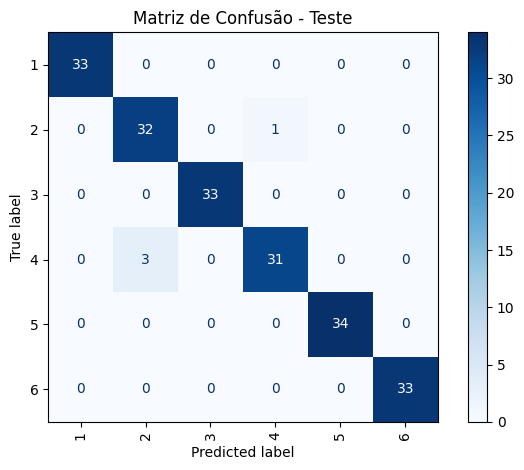

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        33
           2       0.91      0.97      0.94        33
           3       1.00      1.00      1.00        33
           4       0.97      0.91      0.94        34
           5       1.00      1.00      1.00        34
           6       1.00      1.00      1.00        33

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



In [16]:
# Predição no teste
y_test_pred = random_search.predict(X_test)

plot_confusion_matrix(y_test, y_test_pred, le, maior = False, title="Matriz de Confusão - Teste")
classification_metrics(y_test, y_test_pred, le)